# Регионы добычи нефти

### Описание
Необходимо решить где бурить новую скважину нефти. 

Необходимо построить модель для определения региона, где добыча принесет наибольшую прибыль.

### Заказчик:
- "ГлавРосГосНефть"

### Исходные данные:
- данные о пробах нефти в 3 регионах

### Задача:
- построить модель для определения региона, где добыча принесет наибольшую прибыль.

### План работы:
- Загрузить и подготовить (предобработать) данные. 
- Обучить и проверить модель для каждого региона.
- Подготовка к расчету прибыли.
- Расчет прибыли. 
- Посчитать риски. 
- Описать выводы.

### Содержание

## <a href='#section01'>1. Изучение общей информации</a>
* <a href='#section1'>1. Загрузка библиотек и функций, чтение информации</a>
* <a href='#section2'>2. Просмотр данных</a>
* <a href='#section3'>3. Выявление аномалий</a>
* <a href='#section4'>4. Вывод</a>

## <a href='#section02'>2. Исследовательская часть</a>
* <a href='#section21'>1. Предобработка</a>
* <a href='#section22'>2. Подготовка данных</a>
* <a href='#section23'>3. Обучение модели</a>
* <a href='#section24'>4. Подготовка к расчету прибыли</a>
* <a href='#section25'>5. Расчет прибыли</a>
* <a href='#section26'>6. Расчет рисков</a>

## <a href='#section03'>3. Итоговый вывод</a>

### Описание данных:
#### Признаки
- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)
#### Целевой признак
- product — объём запасов в скважине (тыс. баррелей)

<hr style="border: 1px solid #000;">

## <a id=section01>1. Изучение общей информации</a>

### <a id=section1>1. Загрузка библиотек и функций, чтение информации</a>

In [1]:
import pandas
import numpy 
import matplotlib 
import seaborn 
import scipy 

print('pandas version: {}'.format(pandas.__version__))
print('numpy version: {}'.format(numpy.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
print('seaborn version: {}'.format(seaborn.__version__))
print('scipy version: {}'.format(scipy.__version__))

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats as st

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
    
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import SCORERS as sc
from sklearn.utils import shuffle

pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None
#pd.set_option(‘plotting.backend’, ‘plotly’)

import warnings
warnings.filterwarnings("ignore")

state = np.random.RandomState(12345)    #random_state

pandas version: 1.1.3
numpy version: 1.19.2
matplotlib version: 3.3.3
seaborn version: 0.11.0
scipy version: 1.5.2


In [2]:
plt.style.use('grayscale')
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.titleweight'] = 2
#plt.style.available

In [62]:
N_RESEARCHES = 500      #количество исследуемых точек
TOP_RESEARCHES = 200    #количество отобранных точек для проведения работ
BUDGET = 10000          #млн рублей бюджет или 10 млрд рублей на разработку 200 скважин
COST_PER_BARREL = 450   #рублей за 1 баррель
COST_PER_PRODUCT = 0.45 #миллионов рублей с 1 единицы product (с тысячи баррелей)
ALPHA = 0.05            #граница определения вероятности убытков
CV_COUNT = 1000         #количество валидаций
BOOTSTRAP_SIZE=1000     #размерность bootstrap

Загрузил библиотеки и необходимые настройки

In [4]:
try:    
    data1 = pd.read_csv('datasets/geo_data_0.csv')
    data2 = pd.read_csv('datasets/geo_data_1.csv')
    data3 = pd.read_csv('datasets/geo_data_2.csv')
except:
    data1 = pd.read_csv('/datasets/geo_data_0.csv')
    data2 = pd.read_csv('/datasets/geo_data_1.csv')
    data3 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
def missing_value(df):
    missing_value = pd.DataFrame(columns=['NaN_part', 'empty_counts', 'space_counts', '0_counts', '-1_counts', 'unique_counts',\
                                          'min_value', 'max_value', 'dupl_sum', 'dtypes', 'length'], index=df.columns)
    for i in df.columns: 
        missing_value['NaN_part'][i] = df[i].isnull().mean()
        missing_value['empty_counts'][i] = df[df[i] == ''][i].count()
        missing_value['space_counts'][i] = df[df[i] == ' '][i].count()
        missing_value['0_counts'][i] = df[(df[i] == 0)][i].count()
        missing_value['-1_counts'][i] = df[df[i] == -1][i].count()
        missing_value['unique_counts'][i] = len(df[i].unique())
        missing_value['min_value'][i] = df[i].min()
        missing_value['max_value'][i] = df[i].max()
        missing_value['dupl_sum'][i] = df[i].duplicated().sum()
        missing_value['dtypes'][i] = df[i].dtypes
        missing_value['length'][i] = len(df[i])
    print(df.name)
    display(missing_value)

Функция поиска аномалий в данных

In [6]:
def introduction_data(list_df, trigger):
    for df in list_df:
        try:
            if trigger == 0:
                print('-----------------------------------------------------------')
                print('Данные о таблице {}:'.format(df.name))
                print('-----------------------------------------------------------')
                print(df.info())
            if trigger == 1:
                print('Данные о таблице: {}'.format(df.name))
                display(df.head())
            if trigger == 2:
                print('Данные о таблице: {}'.format(df.name))
                display(df.describe())
        except:
            print('ERROR! Выберите один из 3 вариантов:')
            print('вывести info() - выбери 0')
            print('вывести первые 5 строк - выбери 1')
            print('вывести describe() - выбери 2')

Функция просмотра данных

In [7]:
def plot_inspection(data):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,8))
    fig.suptitle(f'Распределение запасов нефти в {data.name.title()}', fontsize=16)
    plt.subplots_adjust(wspace=0.3, hspace=0.25)

    sns.histplot(data, x='f0', bins=500, color='y', kde=True, alpha=0.9, ax=axes[0,0])
    sns.boxplot(data=data, y="f0", ax=axes[0, 1])
    sns.histplot(data, x='f1', bins=500, color='y', kde=True, alpha=0.9, ax=axes[0,2])
    sns.boxplot(data=data, y="f1", ax=axes[0, 3])
    sns.histplot(data, x='f2', bins=500, color='y', kde=True, alpha=0.9, ax=axes[1,0])
    sns.boxplot(data=data, y="f2", ax=axes[1, 1])
    sns.histplot(data, x='product', bins=500, color='y', kde=True, alpha=0.9, ax=axes[1,2])
    sns.boxplot(data=data, y="product", ax=axes[1, 3])

    axes[0,0].set_title(f'Признак {data.columns[1]}', fontsize=12)
    axes[0,2].set_title(f'Признак {data.columns[2]}', fontsize=12)
    axes[1,0].set_title(f'Признак {data.columns[3]}', fontsize=12)
    axes[1,2].set_title(f'Признак {data.columns[4]}', fontsize=12)

    axes[0,1].set_title(f'Признак {data.columns[1]}', fontsize=12)
    axes[0,3].set_title(f'Признак {data.columns[2]}', fontsize=12)
    axes[1,1].set_title(f'Признак {data.columns[3]}', fontsize=12)
    axes[1,3].set_title(f'Признак {data.columns[4]}', fontsize=12)
    plt.show()

Функция визуального просмотра данных

In [8]:
def corr_inspection(list_data): 
    total_axes = len(list_data)        #общее количество графиков (в данном случае берем равным количеству колонок в датафрейме)
    fig = plt.figure(figsize = (15,5))
    fig.suptitle(f'Корреляция признаков в регионах', fontsize=16)
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    subplt = 1                         # номер начального axes

    for data in range(len(list_data)):
        ax = fig.add_subplot(1, total_axes, subplt, facecolor='red')      # добавляем axes для каждого графика
        
        sns.heatmap(
        list_data[data].corr(), ax=ax, cmap='crest_r',
        vmin=-1, vmax=1, center=0,
        annot=True, fmt='.4f', linewidths=.5, #cbar=False
        )
        
        subplt+=1
        ax.set_title(list_data[data].name.title(), fontsize=18)
    plt.show()

Функция просмотра корреляции данных

In [9]:
#функция расчета прибыли 200 самых прибыльных скважин в млн. рублей
def revenue_top(target, pred_reg):
    predicted_top = pd.Series(pred_reg).sort_values(ascending=False)
    revenue_top = target.loc[predicted_top.index][:TOP_RESEARCHES].sum() * COST_PER_PRODUCT - BUDGET
    return revenue_top

Функция расчета прибыли 200 самых прибыльных скважин в млн. рублей

In [53]:
def revenue_distrib(target, pred_reg, count, n):
    values = []
    for i in range(count):
        target_subsample = target.sample(n=n, replace=True, random_state=state)
        pred_subsample = pred_reg.loc[target_subsample.index]               
        revenue = revenue_top(target_subsample, pred_subsample)
        values.append(revenue)
    return(pd.Series(values))

Функция расчета распределения прибыли

In [11]:
def scatter_inspection(list_data): 
    for data in range(len(list_data)):
        print(list_data[data].name.title())
        scatter_matrix(list_data[data], alpha=0.2, diagonal='kde')
    
    plt.show()

Функция расчета scatter_matrix

### <a id=section2>2. Просмотр данных</a>

In [51]:
data1.name = 'регион 1'
data2.name = 'регион 2'
data3.name = 'регион 3'
list_df = [data1, data2, data3]

In [13]:
introduction_data(list_df, 0)

-----------------------------------------------------------
Данные о таблице регион 1:
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-----------------------------------------------------------
Данные о таблице регион 2:
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2

In [14]:
introduction_data(list_df, 1)

Данные о таблице: регион 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Данные о таблице: регион 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Данные о таблице: регион 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [15]:
introduction_data(list_df, 2)

Данные о таблице: регион 1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Данные о таблице: регион 2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Данные о таблице: регион 3


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


### <a id=section3>3. Выявление аномалий</a>

Посмотрю наличие аномалий в данных

In [16]:
missing_value(data1) 
missing_value(data2) 
missing_value(data3) 

регион 1


,NaN_part,empty_counts,space_counts,0_counts,-1_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
id,0,0,0,0,0,99990,006OJ,zzzLH,10,object,100000
f0,0,0,0,0,0,100000,-1.40861,2.36233,0,float64,100000
f1,0,0,0,0,0,100000,-0.848218,1.34377,0,float64,100000
f2,0,0,0,0,0,100000,-12.0883,16.0038,0,float64,100000
product,0,0,0,1,0,100000,0,185.364,0,float64,100000


регион 2


,NaN_part,empty_counts,space_counts,0_counts,-1_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
id,0,0,0,0,0,99996,0022J,zzzvI,4,object,100000
f0,0,0,0,0,0,100000,-31.6096,29.4218,0,float64,100000
f1,0,0,0,0,0,100000,-26.3586,18.7341,0,float64,100000
f2,0,0,0,0,0,100000,-0.0181441,5.01972,0,float64,100000
product,0,0,0,8235,0,12,0,137.945,99988,float64,100000


регион 3


,NaN_part,empty_counts,space_counts,0_counts,-1_counts,unique_counts,min_value,max_value,dupl_sum,dtypes,length
id,0,0,0,0,0,99996,009Gl,zzz9h,4,object,100000
f0,0,0,0,0,0,100000,-8.76,7.23826,0,float64,100000
f1,0,0,0,0,0,100000,-7.08402,7.8448,0,float64,100000
f2,0,0,0,0,0,100000,-11.9703,16.7394,0,float64,100000
product,0,0,0,1,0,100000,0,190.03,0,float64,100000


Из таблиц выше видно:
- второй регион активно используется: 82.3% нефти из существующих скважин добыта. В остальных регионах только по 1 скважине высушено. 
- второй регион имеет 12 уникальных объемов запасов нефти при наличии многочисленных скважин.
- во всех данных по регионам есть малочисленные дубликаты - необходимо удалить. 

Рассмотрю признаки на уникальность:

In [17]:
print(data2.name)
display(sorted(data2['product'].unique()))

регион 2


[0.0,
 3.179102583207246,
 26.953261031539693,
 30.132363614746946,
 53.906522063079386,
 57.08562464628662,
 80.85978309461906,
 84.03888567782631,
 107.81304412615877,
 110.992146709366,
 134.76630515769844,
 137.94540774090564]

In [18]:
print(data1.name)
display(data1[data1.id.duplicated() == True])
print(data2.name)
display(data2[data2.id.duplicated() == True])
print(data3.name)
display(data3[data3.id.duplicated() == True])

регион 1


,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


регион 2


,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


регион 3


,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Необходимо убедиться в том, что признаки не коррелируют между собой. Для этого посмотрю на корреляцию данных:

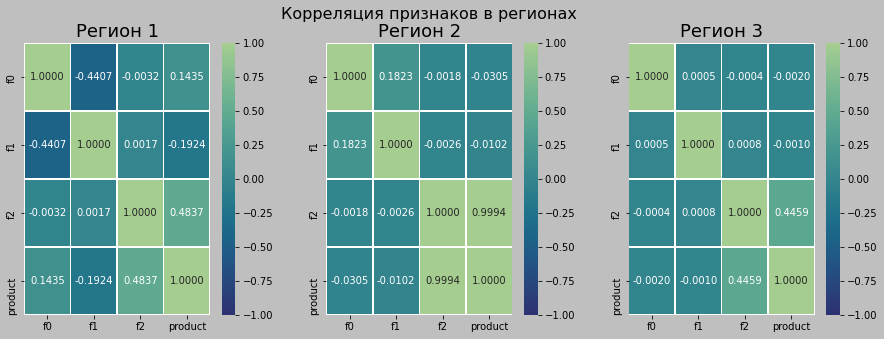

In [20]:
corr_inspection(list_df)

Корреляция выявила крайне высокую связь между запасами нефти во 2 регионе и параметром f2. При этом нет корреляции между признаками, поэтому можно их оставить. Корреляция между признаком и целевым признаком допустима

Посмотрю на распределения данных:

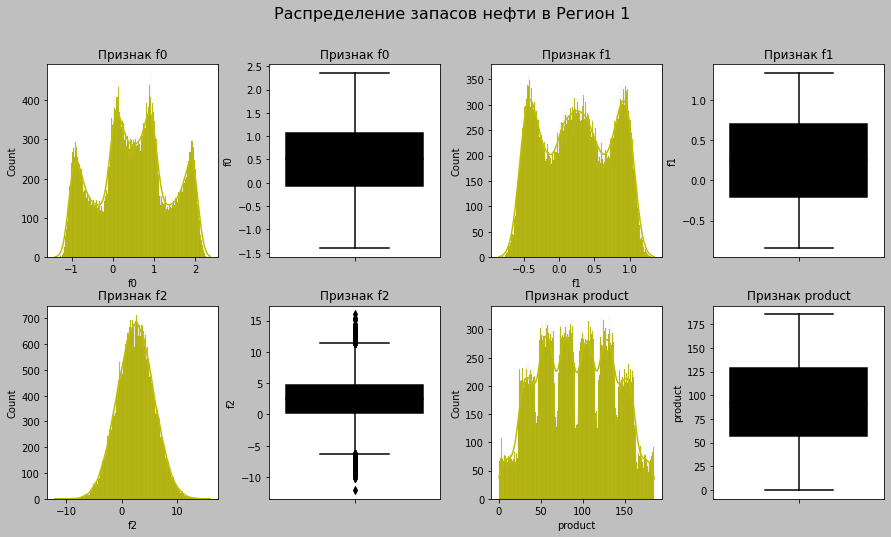

In [21]:
plot_inspection(data1)

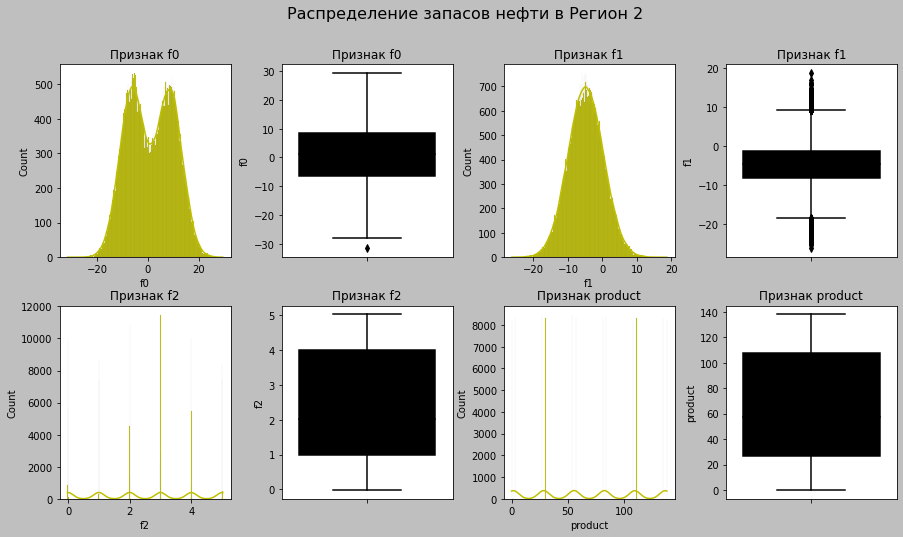

In [22]:
plot_inspection(data2)

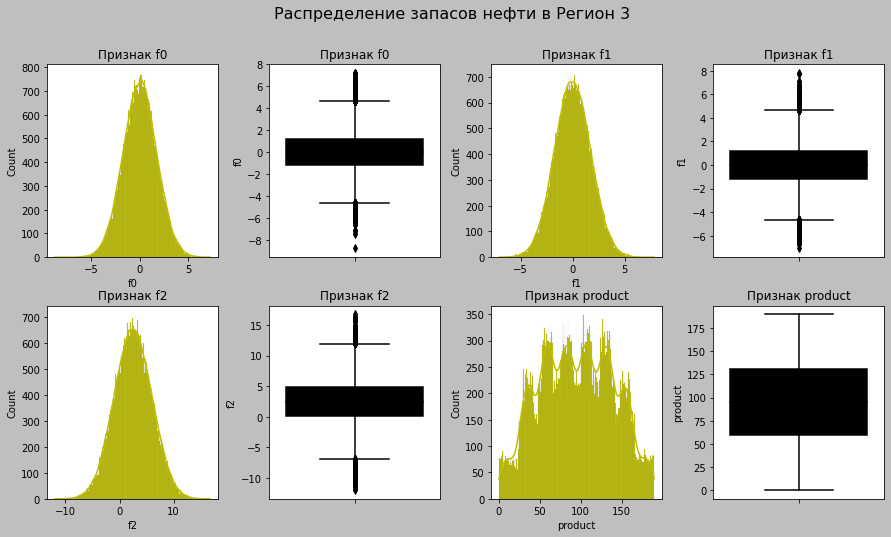

In [23]:
plot_inspection(data3)

### <a id=section4>4. Вывод</a>

Аномалий нет:
- есть дубликаты
- что-то надо сделать с 0 в столбце 'product' региона 2.
- график f2 региона 2 выглядит странно, аномалий не было выявлено
- график 'ploduct' региона 2 имеет много 0, поэтому он вышел таким
- высокая корреляция между 'f2' and 'product' в регионе 2
- относительно сильная корреляция между 'f2' and 'product' в остальных регионах

Вывод:
- надо обратить внимание на признак 'f2'
- дубликаты обрабатывать не надо, они не мешают построению модели
- спросить у Заказчина причину наличия всего 12 уникальных значений 'product' в регионе 2

`Вопросы`:
- надо ли обрабатывать выбросы?
- есть бимодальные и многомодальные распределения. В соответствии с ЦПТ нам все равно на это или все-таки надо что-то предпринимать?
- с 0 в столбце 'product' региона 2 делать ничего не требуется?

<hr style="border: 1px solid #000;">

## <a id=section02>2. Исследовательская часть</a>

### <a id=section21>1. Предобработка</a>

Сделаю необходимую предобработку

In [24]:
data1 = data1.drop(columns=['id'])
data2 = data2.drop(columns=['id'])
data3 = data3.drop(columns=['id'])

In [25]:
display(data1.sort_values(by='product', ascending=False).head())

,f0,f1,f2,product
8826,1.797736,0.098212,6.148260,185.364347
99818,0.518445,-0.412790,4.951916,185.362690
94175,0.351428,-0.400244,7.227618,185.355615
1925,0.624430,-0.469312,5.753677,185.354980
45291,1.758787,-0.395038,6.719085,185.352015


### <a id=section22>2. Подготовка данных</a>

Теперь начну работу по созданию модели

In [26]:
#отделяю целевой признак от остальных признаков
features_1 = data1.drop('product', axis=1)
target_1 = data1['product']

features_2 = data2.drop('product', axis=1)
target_2 = data2['product']

features_3 = data3.drop('product', axis=1)
target_3 = data3['product']

In [27]:
#разбиваю датасет на обучающую, проверочную и тестовую выборки
features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
features_1, target_1, test_size=0.25, random_state=state)

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
features_2, target_2, test_size=0.25, random_state=state)

features_3_train, features_3_valid, target_3_train, target_3_valid = train_test_split(
features_3, target_3, test_size=0.25, random_state=state)

Теперь необходимо сбросить индексы и провести масштабирование обучающего и проверочного выборок

In [28]:
features_1_train = features_1_train.reset_index(drop=True)
features_2_train = features_2_train.reset_index(drop=True)
features_3_train = features_3_train.reset_index(drop=True)

In [29]:
print(features_1_train.head())

         f0        f1        f2
0  0.022450  0.951034  2.197333
1  1.766731  0.007835  6.436602
2  0.724514  0.666063  1.840177
3 -1.104181  0.255268  2.026156
4 -0.635263  0.747990  6.643327


In [30]:
#масштабирую признаки через алгоритм StandardScaler
scaler = StandardScaler()

scaler.fit(features_1_train)
features_1_train = pd.DataFrame(scaler.transform(features_1_train), columns=features_1_train.columns)
features_1_valid = pd.DataFrame(scaler.transform(features_1_valid), columns=features_1_valid.columns)

scaler.fit(features_2_train)
features_2_train = pd.DataFrame(scaler.transform(features_2_train), columns=features_2_train.columns)
features_2_valid = pd.DataFrame(scaler.transform(features_2_valid), columns=features_2_valid.columns)

scaler.fit(features_2_train)
features_3_train = pd.DataFrame(scaler.transform(features_3_train), columns=features_3_train.columns)
features_3_valid = pd.DataFrame(scaler.transform(features_3_valid), columns=features_3_valid.columns)

In [31]:
#вывожу размерность выборок
print(features_1_train.shape)
print(features_1_valid.shape)
print(target_1_train.shape)
print(target_1_valid.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


### <a id=section23>3. Обучение модели</a>

Посчитаю метрики линейной регрессии для полученных выборок:
- MSE - среднеквадратичная ошибка отклонений измерений. Из-за квадрата в числителе разные измерения имеют разный вес влияния на метрику. Чем меньше, тем лучше.
- RMSE - корень из MSE. Фактически приводит к общей мерности измеряемой величины, полезна для практического использования. Чем меньше, тем лучше.
- R2 - коэффициент детерминации. Показывает долю среднеквадратичной ошибки прогноза модели относительно среднеквадратичной ошибки правильных ответов.Чем выше коэффициент, тем лучше.
- MAE - среднее абсолютное отклонение. Показывает абсолютное отклонение правильных измерений от прогнозируемых. Берется не квадрат, а модуль. Чем меньше, тем лучше.

In [32]:
model = LinearRegression()

In [33]:
#kfold = model.selection.Kfold(n_splits=10, random_state=state) #вместо СV_COUNT
pred_reg1 = cross_val_predict(model, features_1, target_1, cv=CV_COUNT)
pred_reg1 = pd.Series(pred_reg1)
display(pred_reg1.head()) 

0     95.350352
1    116.264179
2     88.704068
3     95.193309
4    114.304125
dtype: float64

In [34]:
print('r2', r2_score(target_1, pred_reg1))
print('MSE', mean_squared_error(target_1, pred_reg1))
print('RMSE', mean_squared_error(target_1, pred_reg1) ** 0.5)
print('MAE', mean_absolute_error(target_1, pred_reg1))

r2 0.2756543593492765
MSE 1420.781191824607
RMSE 37.693251276914374
MAE 31.038521834689718


In [35]:
#sorted(sc.keys())

In [36]:
scores = cross_validate(model, features_1, target_1, cv=CV_COUNT, scoring=('r2'), return_train_score=True, return_estimator=True)
display(pd.DataFrame(scores))

,fit_time,score_time,estimator,test_score,train_score
0,0.010527,0.000502,LinearRegression(),0.155504,0.275813
1,0.010026,0.001504,LinearRegression(),0.226501,0.275754
2,0.011066,0.002005,LinearRegression(),0.296776,0.275681
3,0.011531,0.002005,LinearRegression(),0.325453,0.275637
4,0.012033,0.002005,LinearRegression(),0.228258,0.275769
...,...,...,...,...,...
995,0.009526,0.001504,LinearRegression(),0.309108,0.275677
996,0.009525,0.001504,LinearRegression(),0.190211,0.275782
997,0.009525,0.001504,LinearRegression(),0.253564,0.275724
998,0.009024,0.002005,LinearRegression(),0.272047,0.275698


In [37]:
pred_reg2 = cross_val_predict(model, features_2, target_2, cv=CV_COUNT)
pred_reg2 = pd.Series(pred_reg2)
display(pred_reg2.head())

0      3.848707
1     26.591341
2    135.665464
3    138.541466
4    134.866232
dtype: float64

In [38]:
print('r2', r2_score(target_2, pred_reg2))
print('MSE', mean_squared_error(target_2, pred_reg2))
print('RMSE', mean_squared_error(target_2, pred_reg2) ** 0.5)
print('MAE', mean_absolute_error(target_2, pred_reg2))

r2 0.9996244075020216
MSE 0.7928265178924098
RMSE 0.8904080625715435
MAE 0.7174010042018216


In [39]:
scores = cross_validate(model, features_1, target_1, cv=CV_COUNT, scoring=('r2'), return_train_score=True, return_estimator=True)
display(pd.DataFrame(scores))

,fit_time,score_time,estimator,test_score,train_score
0,0.010527,0.002005,LinearRegression(),0.155504,0.275813
1,0.009525,0.001504,LinearRegression(),0.226501,0.275754
2,0.009024,0.002005,LinearRegression(),0.296776,0.275681
3,0.010528,0.001504,LinearRegression(),0.325453,0.275637
4,0.009939,0.001503,LinearRegression(),0.228258,0.275769
...,...,...,...,...,...
995,0.009024,0.002040,LinearRegression(),0.309108,0.275677
996,0.009050,0.001511,LinearRegression(),0.190211,0.275782
997,0.009526,0.001534,LinearRegression(),0.253564,0.275724
998,0.009526,0.002037,LinearRegression(),0.272047,0.275698


In [40]:
model = LinearRegression()
pred_reg3 = cross_val_predict(model, features_3, target_3, cv=CV_COUNT)
pred_reg3 = pd.Series(pred_reg3)
display(pred_reg3.head())

0     75.928769
1     66.114204
2     48.561421
3     85.925237
4    114.518372
dtype: float64

In [41]:
print('r2', r2_score(target_3, pred_reg3))
print('MSE', mean_squared_error(target_3, pred_reg3))
print('RMSE', mean_squared_error(target_3, pred_reg3) ** 0.5)
print('MAE', mean_absolute_error(target_3, pred_reg3))

r2 0.19874337869459013
MSE 1604.544756759673
RMSE 40.05676917525517
MAE 32.8213952866228


In [42]:
scores = cross_validate(model, features_1, target_1, cv=CV_COUNT, scoring=('r2'), return_train_score=True, return_estimator=True)
display(pd.DataFrame(scores))

,fit_time,score_time,estimator,test_score,train_score
0,0.012032,0.002006,LinearRegression(),0.155504,0.275813
1,0.009524,0.001504,LinearRegression(),0.226501,0.275754
2,0.010027,0.001504,LinearRegression(),0.296776,0.275681
3,0.009525,0.001504,LinearRegression(),0.325453,0.275637
4,0.010027,0.001504,LinearRegression(),0.228258,0.275769
...,...,...,...,...,...
995,0.009525,0.002005,LinearRegression(),0.309108,0.275677
996,0.009525,0.001504,LinearRegression(),0.190211,0.275782
997,0.010528,0.001504,LinearRegression(),0.253564,0.275724
998,0.010027,0.001504,LinearRegression(),0.272047,0.275698


Среднеквадратичная ошибка составляе около 40 в регионах 1 и 3, почти 1 в регионе 2. Это при том, что распределение единичное и стандартное отклонение выборок std=1. Это очень большая ошибка, она не дает понимания примерных запасов нефти. Метрики показывают, что построенная линейная модель очень плоха. R2 должен быть высоким, до 1 единицы, остальные метрики как можно меньше, до 0. У меня картина ровно наоборот. Хорошая метрика R2 только во втором регионе, но даже здесь высокое RMSE, около 1 при std=1.

### <a id=section24>4. Подготовка к расчету прибыли</a>

Посчитаю сколько нужно добыть нефти, чтобы обеспечить безубыточность разработки скважины

In [43]:
oil_breakeven = BUDGET / COST_PER_PRODUCT
print(f'Безубыточный объем добычи нефти составляет {oil_breakeven:.2f} тыс. баррелей')

Безубыточный объем добычи нефти составляет 22222.22 тыс. баррелей


Так как планируется разрабатывать 200 скважин, то необходимо посчитать минимально необходимую величину разработки запасов нефти с 1 из 200 скважин

In [44]:
oil_breakeven_per_one = oil_breakeven / TOP_RESEARCHES
print(f'Безубыточный объем добычи нефти с 1 скважины из 200 составляет {oil_breakeven_per_one:.2f} тыс. баррелей')

Безубыточный объем добычи нефти с 1 скважины из 200 составляет 111.11 тыс. баррелей


In [45]:
print(f'Средний запас нефти в одной скважине региона 1 составляет {data1["product"].mean():.2f} тыс. баррелей')
print(f'Средний запас нефти в одной скважине региона 2 составляет {data2["product"].mean():.2f} тыс. баррелей')
print(f'Средний запас нефти в одной скважине региона 3 составляет {data3["product"].mean():.2f} тыс. баррелей')

Средний запас нефти в одной скважине региона 1 составляет 92.50 тыс. баррелей
Средний запас нефти в одной скважине региона 2 составляет 68.83 тыс. баррелей
Средний запас нефти в одной скважине региона 3 составляет 95.00 тыс. баррелей


In [46]:
print(f'Медиана запаса нефти в одной скважине региона 1 составляет {data1["product"].median():.2f} тыс. баррелей')
print(f'Медиана запаса нефти в одной скважине региона 2 составляет {data2["product"].median():.2f} тыс. баррелей')
print(f'Медиана запаса нефти в одной скважине региона 3 составляет {data3["product"].median():.2f} тыс. баррелей')

Медиана запаса нефти в одной скважине региона 1 составляет 91.85 тыс. баррелей
Медиана запаса нефти в одной скважине региона 2 составляет 57.09 тыс. баррелей
Медиана запаса нефти в одной скважине региона 3 составляет 94.93 тыс. баррелей


In [47]:
volume_1 = data1['product'].sum()
volume_2 = data2['product'].sum()
volume_3 = data3['product'].sum()
print(f'Запас нефти в регионе 1 - {volume_1:.0f} тыс. баррелей')
print(f'Запас нефти в регионе 2 - {volume_2:.0f} тыс. баррелей')
print(f'Запас нефти в регионе 3 - {volume_3:.0f} тыс. баррелей')

Запас нефти в регионе 1 - 9250000 тыс. баррелей
Запас нефти в регионе 2 - 6882500 тыс. баррелей
Запас нефти в регионе 3 - 9500000 тыс. баррелей


In [48]:
mean_reg = (volume_1 + volume_2 + volume_3).mean()
print('Доля безубыточного объема запасов нефти от всех объемов в трех регионах составляет:', oil_breakeven * 100 / mean_reg ,'%')

Доля безубыточного объема запасов нефти от всех объемов в трех регионах составляет: 0.0866954929180619 %


Для того, чтобы обеспечить безубыточность разработки скважин необходимо добыть 22 222 тыс. баррелей. Если сравнить этот объем со всем объемом запасов нефти, то он составляет 0.09%, остальное является прибылью - золотая жила. (не верно, так как бюджет дан на 200 скважин)

Для обеспечения безубыточности 200 запланированных скважин необходимо добыть не менее 111.11 тыс. баррелей. Однако средняя по всем 3 регионам явно меньше, поэтому требуется найти найти точки, где будет обеспечиваться добыча свыше 111 тыс. баррелей. Для этого надо найти точки в регионах, в которых выполняется это условие.

### <a id=section25>5. Расчет прибыли</a>

In [49]:
top_income_reg1 = revenue_top(target_1, pred_reg1)
print(f'Прибыль от 200 скважин в регионе 1: {top_income_reg1:.2f} млн рублей')
top_income_reg2 = revenue_top(target_2, pred_reg2)
print(f'Прибыль от 200 скважин в регионе 2: {top_income_reg2:.2f} млн рублей')
top_income_reg3 = revenue_top(target_3, pred_reg3)
print(f'Прибыль от 200 скважин в регионе 3: {top_income_reg3:.2f} млн рублей')

Прибыль от 200 скважин в регионе 1: 3492.33 млн рублей
Прибыль от 200 скважин в регионе 2: 2415.09 млн рублей
Прибыль от 200 скважин в регионе 3: 2583.66 млн рублей


Это максимальная прибыль компании с 200 скважин с известных разработанных точек. Для предсказания мне необходимо рассмотреть 500 случайных точек. Это смоделирует точки с разной вероятностной прибылью - потенциальные точки могут оказаться с крайне малыми запасами нефти. Из этих 500 случайных точек надо выбрать 200 с максимальными запасами нефти, так как бюджет выделен именно на 200 точек. Затем необходимо будет оценить потенциальную прибыль.

### <a id=section26>6. Расчет рисков</a>

Сначала необходимо получить распределение прибыли

In [54]:
revenue_distrib_reg1 = revenue_distrib(target_1, pred_reg1, count=BOOTSTRAP_SIZE, n=N_RESEARCHES)
revenue_distrib_reg2 = revenue_distrib(target_2, pred_reg2, count=BOOTSTRAP_SIZE, n=N_RESEARCHES)
revenue_distrib_reg3 = revenue_distrib(target_3, pred_reg3, count=BOOTSTRAP_SIZE, n=N_RESEARCHES)

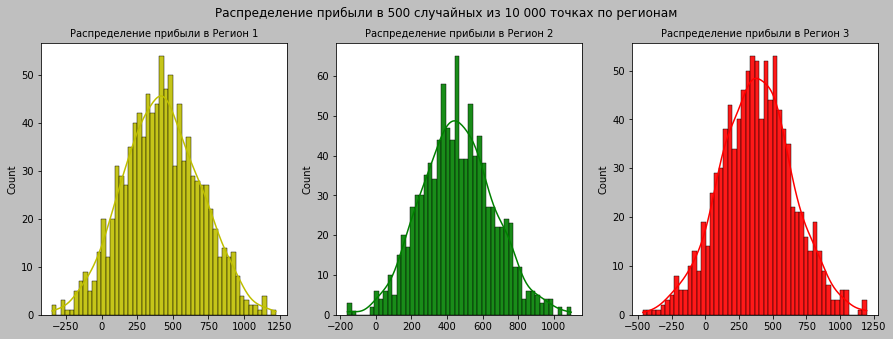

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (15,5))
fig.suptitle(f'Распределение прибыли в 500 случайных из 10 000 точках по регионам', fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.9)

sns.histplot(revenue_distrib_reg1, bins=50, color='y', kde=True, alpha=0.9, ax=ax1)
sns.histplot(revenue_distrib_reg2, bins=50, color='g', kde=True, alpha=0.9, ax=ax2)
sns.histplot(revenue_distrib_reg3, bins=50, color='r', kde=True, alpha=0.9, ax=ax3)

ax1.set_title(f'Распределение прибыли в {data1.name.title()}', fontsize=10)
ax2.set_title(f'Распределение прибыли в {data2.name.title()}', fontsize=10)
ax3.set_title(f'Распределение прибыли в {data3.name.title()}', fontsize=10)

#revenue_distrib_reg1.plot(kind='hist', subplots=True, layout=(1,3), sharex=True, sharey=True) #share нормализует графики!

plt.show()

Построю доверительные интервалы для каждого из региона

In [68]:
confidence_interval_reg1 = st.t.interval(1 - ALPHA, len(revenue_distrib_reg1) - 1, revenue_distrib_reg1.mean(), revenue_distrib_reg1.std())
confidence_interval_reg2 = st.t.interval(1 - ALPHA, len(revenue_distrib_reg2) - 1, revenue_distrib_reg2.mean(), revenue_distrib_reg2.std())
confidence_interval_reg3 = st.t.interval(1 - ALPHA, len(revenue_distrib_reg3) - 1, revenue_distrib_reg3.mean(), revenue_distrib_reg3.std())
print(f'Доверительный интервал для региона 1: {confidence_interval_reg1}')
print(f'Доверительный интервал для региона 2: {confidence_interval_reg2}')
print(f'Доверительный интервал для региона 3: {confidence_interval_reg3}')

Доверительный интервал для региона 1: (-105.7818324670551, 949.386915412735)
Доверительный интервал для региона 2: (61.04231919597555, 855.7676157167458)
Доверительный интервал для региона 3: (-152.03030321451342, 907.2876897305744)


In [65]:
def conf_interval(sample):
    std = np.std(sample, ddof=1)
    sample_size = np.ptp(sample)
    se = std / np.sqrt(sample_size)
    sigma = st.norm().isf(ALPHA/2)
    mean = sample.mean()
    confidence_interval = mean - sigma*std, mean + sigma*std
    print(f"Доверительный интервал для региона в {(1-ALPHA)*100:.2f}% ", end='')
    print('[%.2f; %.2f]' % confidence_interval)

In [66]:
conf_interval(revenue_distrib_reg1)
conf_interval(revenue_distrib_reg2)
conf_interval(revenue_distrib_reg3)

Доверительный интервал для региона в 95.00% [-105.14; 948.75]
Доверительный интервал для региона в 95.00% [61.52; 855.29]
Доверительный интервал для региона в 95.00% [-151.39; 906.65]


In [67]:
conf_interval_reg1 = (revenue_distrib_reg1.quantile(ALPHA/2), revenue_distrib_reg1.quantile(1-ALPHA/2))
conf_interval_reg2 = (revenue_distrib_reg2.quantile(ALPHA/2), revenue_distrib_reg2.quantile(1-ALPHA/2))
conf_interval_reg3 = (revenue_distrib_reg3.quantile(ALPHA/2), revenue_distrib_reg3.quantile(1-ALPHA/2))
print(f'Доверительный интервал для региона 1: {conf_interval_reg1}')
print(f'Доверительный интервал для региона 2: {conf_interval_reg2}')
print(f'Доверительный интервал для региона 3: {conf_interval_reg3}')

Доверительный интервал для региона 1: (-104.12561131066613, 940.5062139247005)
Доверительный интервал для региона 2: (75.87537158733208, 871.8746263290487)
Доверительный интервал для региона 3: (-167.551986411258, 906.5869907175776)


Посчитаю риски

In [60]:
risk_reg1 = (revenue_distrib_reg1 < 0).mean() * 100
risk_reg2 = (revenue_distrib_reg2 < 0).mean() * 100
risk_reg3 = (revenue_distrib_reg3 < 0).mean() * 100
print(f'Риск убытков для региона 1: {risk_reg1:.2f}%')
print(f'Риск убытков для региона 2: {risk_reg2:.2f}%')
print(f'Риск убытков для региона 3: {risk_reg3:.2f}%')

Риск убытков для региона 1: 5.60%
Риск убытков для региона 2: 0.80%
Риск убытков для региона 3: 8.20%


In [61]:
risk_reg1 = st.percentileofscore(revenue_distrib_reg1, 0)
risk_reg2 = st.percentileofscore(revenue_distrib_reg2, 0)
risk_reg3 = st.percentileofscore(revenue_distrib_reg3, 0)
print(f'Риск убытков для региона 1: {risk_reg1:.2f}%')
print(f'Риск убытков для региона 2: {risk_reg2:.2f}%')
print(f'Риск убытков для региона 3: {risk_reg3:.2f}%')

Риск убытков для региона 1: 5.60%
Риск убытков для региона 2: 0.80%
Риск убытков для региона 3: 8.20%


## <a id=section03>3. Итоговый вывод</a>

В ходе выполнения исследования я применил следующие модели:
- линейная регрессия

Оценка исследования проводилась по следующим метрикам:
- MSE - среднеквадратичная ошибка отклонений измерений. Из-за квадрата в числителе разные измерения имеют разный вес влияния на метрику. Чем меньше, тем лучше.
- RMSE - корень из MSE. Фактически приводит к общей мерности измеряемой величины, полезна для практического использования. Чем меньше, тем лучше.
- R2 - коэффициент детерминации. Показывает долю среднеквадратичной ошибки прогноза модели относительно среднеквадратичной ошибки правильных ответов.Чем выше коэффициент, тем лучше.
- MAE - среднее абсолютное отклонение. Показывает абсолютное отклонение правильных измерений от прогнозируемых. Берется не квадрат, а модуль. Чем меньше, тем лучше.
Выяснилось, что метрики у данной модели достаточно низкие, но если верить условию задачи, то линейная регрессия является самой лучшей моделью.

Наилучшие места для проведения бурения определяются исходя из условия минимизации рисков получения убытков. Наиболее уверенным я могу быть во втором регионе - риск получения убытков меньше 1%.